## 範例
今天的課程大家應該可以了解到 YOLO 的網路輸出是一個 7x7x30 的 tensor,

而今天的程式碼範例的目標是讓大家由程式碼直觀地去理解，一張圖片經過 YOLO 網路之後，這個 7x7x30 的 tensor 裡面的值應該是什麼樣子？

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("dog (2).jpg") # 讀取範例圖片
h, w, _ = img.shape

顯示一下今天的範例圖，可以觀察到圖片裡面有 狗、腳踏車和一輛車

In [2]:
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # plt.imshow 預設圖片是 rgb 的
    plt.show()

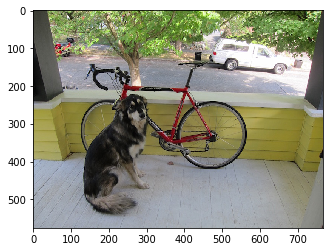

In [3]:
show(img)

假設我們知道這張中汽車、狗和腳踏車的 bboxes 訊息

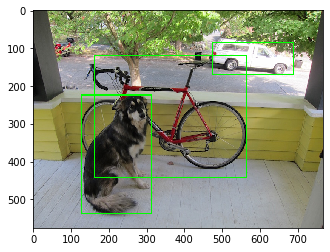

In [13]:
boxes = np.array([[128, 224, 314, 537], [475, 85, 689, 170], [162, 119, 565, 441]]).astype(float)
# 把 bboxes 坐標以原圖的 resolution normalize 到 0~1 之間
boxes[:, [0, 2]] = boxes[:, [0, 2]] / img.shape[1]
boxes[:, [1, 3]] = boxes[:, [1, 3]] / img.shape[0]

img_show = img.copy()
for x1, y1, x2, y2 in boxes:
    cv2.rectangle(img_show, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), (0, 255, 0), 2)
show(img_show)

假設我們用的是 VOC 資料集, 這是一個標註有 20 類物體的資料集, 介紹可以看[這邊](https://arleyzhang.github.io/articles/1dc20586/), 汽車、狗和腳踏車所對應的 class index 分別是 1, 7, 16

In [17]:
labels = np.array([1, 7, 16]) 

有了 bboxes 以及類別的信息，接下來我們就來建構這張圖片在經過 YOLO 網路後應該要輸出的 tensor

In [18]:
grid_num = 7 # 把圖片切成 7x7 的網格
target = np.zeros((grid_num, grid_num, 30)) # 初始化 YOLO 目標預測值, 30 代表什麼, 請參考簡報
print("YOLO 網路輸出 tensor 的 shape: ", target.shape)

YOLO 網路輸出 tensor 的 shape:  (7, 7, 30)


In [33]:
# 主要建構邏輯
cell_size = 1./grid_num # 一個網格的大小
wh = boxes[:,2:]-boxes[:,:2] # bboxes 的 width 以及 height
cxcy = (boxes[:,2:]+boxes[:,:2])/2 # bboxes 的中心
for i in range(len(boxes)):
    cxcy_sample = cxcy[i]
    ij = np.ceil((cxcy_sample/cell_size))-1 # bboxes 中心所坐落的網路 index
    target[int(ij[1]),int(ij[0]),4] = 1 # 該網格第一個 box 的 confidence 信息 
    target[int(ij[1]),int(ij[0]),9] = 1 # 該網格第二個 box 的 confidence 信息
    target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1 # 該網格的類別信息
    xy = ij*cell_size # 匹配到的網格的左上角相對坐標
    # 該網格的 x,y,w,h
    delta_xy = (cxcy_sample -xy)/cell_size
    target[int(ij[1]),int(ij[0]),2:4] = wh[i]
    target[int(ij[1]),int(ij[0]),:2] = delta_xy
    target[int(ij[1]),int(ij[0]),7:9] = wh[i]
    target[int(ij[1]),int(ij[0]),5:7] = delta_xy
    
print("顯示 7x7x30 中，第一個 box 的 confidence 信息\n", target[:, :, 4])

顯示 7x7x30 中，第一個 box 的 confidence 信息
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


上面的 tensor 中, 為 1 的表示那個網格是有物體的, 為 0 就表示沒有物體

我們可以把帶有 7x7 網格的圖畫出來比對一下，

看看汽車、狗和腳踏車的中心是不是恰好就是這個 tensor 中值為 1 的網格呢

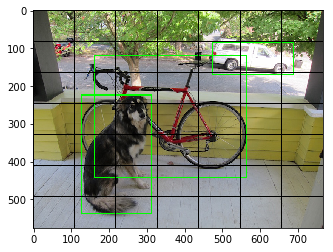

In [8]:
for h in np.arange(0, img.shape[0], img.shape[0]/grid_num).astype(int):
    cv2.line(img_show, (0, h), (img.shape[1], h), (0, 0, 0), 2)
for w in np.arange(0, img.shape[1], img.shape[1]/grid_num).astype(int):
    cv2.line(img_show, (w, 0), (w, img.shape[0]), (0, 0, 0), 2)
show(img_show)

## 作業
相信今天的簡報還有程式碼範例的信息量已經足夠大了，可以多花時間消化簡報和程式碼範例，作業就問一個非常簡單的問題來確保大家有理解到重點，請問在 YOLOv1 的設計下，一張圖片最多能檢測出多少個 bbox 呢？

一張圖片有 7x7 網格，每個網格有 2 個 bbox，因此總共有 7x7x2 = 98 個 bbox。